# WGAN - Wasserstein GAN

As Wasserstein GANs (WGANs) são um tipo de rede adversária generativa proposta em 2017 por pesquisadores do DeepMind e Universidade Federal de Toulouse. Elas trazem as seguintes melhorias:

- Utilizam a distance métrica Wasserstein ou "Earth Mover's Distance" ao invés da loss function tradicional baseada na entropia cruzada das GANs originais. Isso melhora a estabilidade do treinamento.

- O discriminador passa a se chamar "critic" e ao invés de classificar as amostras como real ou fake, ele estima quão próximas as amostras geradas estão em relação às amostras reais. 

- Para garantir lipschitz-continuidade, é utilizado um "clipping" dos pesos do critic após cada atualização dos parâmetros. Isso também ajuda na estabilidade.

- Não há necessidade de usar nenhuma técnica especial de regularização como dropout, batch normalization etc. O clipping já cumpre esse papel.

- Têm mostrado resultados superiores na geração de imagens com mais nitidez e menos artefatos e deformações.

- Abriram caminho para variações ainda melhores como as WGAN-GP, que usam gradient penalty ao invés de clipping dos pesos.

Portanto, as WGANs representaram um grande avanço na qualidade e desempenho de GANs para geração sintética de dados.

## Importação das bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.0.0'

## Carregamento e pré-processamento da base de dados

In [2]:
(X_treinamento, y_treinamento), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
X_treinamento.shape, y_treinamento.shape

((60000, 28, 28), (60000,))

In [4]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [5]:
X_treinamento.shape

(60000, 28, 28, 1)

In [6]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [7]:
buffer_size = y_treinamento.shape[0] #60000
batch_size = 256

X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

## Construção do Gerador

Usaremos a mesma arquitetura do gerador que usamos na implementação do DCGAN

In [9]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [10]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [11]:
gerador.input

<tf.Tensor 'dense_input:0' shape=(None, 100) dtype=float32>

In [12]:
ruido = tf.random.normal([1, 100])
print(ruido)

tf.Tensor(
[[-0.63937443  1.1227146  -0.41092402  1.5801548   0.9543949  -0.21359202
   0.3710003   0.9008626   0.42023996  0.14022954 -1.3764865   0.45591733
   0.01826428 -0.6867227  -0.79969114 -1.5014062  -0.66544926 -0.19839196
   1.1103836  -0.76953983 -0.9595084   0.30406895  0.84101295 -1.326886
  -1.2424401   1.0339924   1.2991441  -0.8020605  -0.6858614   0.28949127
  -0.23019662 -0.32790157  0.07217992 -0.9806209   0.9455645   1.9437834
   1.5177829  -0.6518966   2.4353766  -1.1632833   1.0087515   2.058361
  -0.7465639  -1.3727311   0.1575224   0.32046416 -1.5453931   0.32907927
  -0.7639711  -0.23719412 -0.5294546  -0.23758245 -0.90683585 -0.9993711
  -0.73152244  0.8334986  -1.5831969   1.7961258  -2.5031567  -1.1504161
   0.9198676  -1.0806489   0.06230872  1.4446399  -1.3415625  -0.45892814
   0.65707    -0.1949543  -0.46234608  0.6459628   1.2175418   0.7989869
  -0.20038776 -0.0853157   1.0763913   0.17325819 -0.9858921   1.2672855
   1.8746758  -0.62792724  0.7544173

(1, 28, 28, 1)


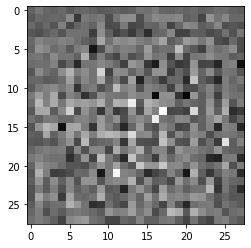

In [13]:
imagem_gerada = gerador(ruido, training = False)
print(imagem_gerada.shape)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

## Construção do Discriminador

Obs: No contexto de WGAN, o discriminador é chamado também de Crítico

In [15]:
def cria_discriminador():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [16]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [17]:
discriminador.input

<tf.Tensor 'conv2d_input:0' shape=(None, 28, 28, 1) dtype=float32>

In [18]:
resultado = discriminador(imagem_gerada)
print(resultado)

tf.Tensor([[-0.00142067]], shape=(1, 1), dtype=float32)



## Funções de perda **Wasserstein Loss**

A perda (*loss*) é a diferença entre o valor esperado da saída do discriminador para imagens autênticas e o valor esperado do discriminador para imagens falsas que foram geradas.

* O objetivo do discriminador é maximizar essa diferença, enquanto que o objetivo do gerador é minimizar.

Então, podemos criar o loss/perda para podermos monitorar os estágios de treinamento.

In [19]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.95])

<tf.Tensor: id=788, shape=(), dtype=float32, numpy=-0.68333334>

In [20]:
def loss_gerador(fake_saida):
  g_loss = -1. * tf.math.reduce_mean(fake_saida)
  return g_loss

In [21]:
def loss_discriminador(real_saida, fake_saida, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_saida) - tf.math.reduce_mean(real_saida) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Parâmetros beta: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 Para usar a perda de Wasserstein, nosso discriminador precisa ser **1-L** [(1-Lipschitz) contínuo](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt), ou seja, a norma do gradiente deve ser no máximo 1 em cada ponto.

Para impor a continuidade de 1-L usaremos o conceito de **Gradient Penalty**.

Essa variação foi apelidada de **WGAN-GP** (devido ao uso do **G**radient **P**enalty)

(Mais sobre Gradient Penalty [nesse artigo](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Para calcular o gradient penalty faremos o seguinte:
1. Calcular uma imagem interpolada da imagem real e fake (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calcular o gradiente da saída do discriminador em relação à imagem interpolada. Depois disso, calcular a norma do gradiente.
3. Por fim, a penalidade é calculada como uma média do quadrado de (norma - 1), pois queremos que a norma seja próxima de um.

Para trabalhar com algumas das operações envolvendo gradiente usamos o  [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [22]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  imgs_interpoladas = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(imgs_interpoladas)
    scores = discriminador(imgs_interpoladas)
  gradient = tape.gradient(scores, imgs_interpoladas)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [23]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefixo = os.path.join(checkpoint_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(generator_optimizer = gerador_optimizer,
                                 discrimanator_optimizer = discriminador_optimizer,
                                 generator=gerador,
                                 discriminator=discriminador)

## Treinamento da GAN e visualização dos resultados

In [31]:
epochs = 30
noise_dim = 100
num_amostras = 16
seed = tf.random.normal([num_amostras, noise_dim])

In [26]:
seed

<tf.Tensor: id=794, shape=(16, 100), dtype=float32, numpy=
array([[-9.27187204e-01,  6.88414574e-01,  9.75743495e-03, ...,
        -9.43651974e-01, -3.45081873e-02, -2.57509887e-01],
       [ 4.41953868e-01,  7.80562579e-04,  9.52664971e-01, ...,
        -6.92464888e-01, -9.39844906e-01, -1.11323810e+00],
       [-6.51576519e-01, -1.32355809e+00, -5.17938972e-01, ...,
         8.52763116e-01, -1.48964271e-01,  1.07990336e+00],
       ...,
       [ 5.55496931e-01,  5.07702768e-01, -2.19545245e-01, ...,
        -1.73714712e-01, -9.71449390e-02,  1.79231495e-01],
       [ 1.02526195e-01, -3.14773053e-01,  9.63700116e-01, ...,
         6.38835907e-01,  1.02902782e+00, -2.25228652e-01],
       [-2.48140669e+00,  2.66927958e-01,  1.05203760e+00, ...,
        -9.42845941e-02,  4.18980002e-01, -3.95406693e-01]], dtype=float32)>

In [32]:
def etapa_treinamento(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminador_etapas_extras = 3
  for i in range(discriminador_etapas_extras):
    with tf.GradientTape() as d_tape:
      imgs_geradas = gerador(noise, training = True)
      real_saida = discriminador(imgs, training = True)
      fake_saida = discriminador(imgs_geradas, training=True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(imgs, imgs_geradas, epsilon)

      d_loss = loss_discriminador(real_saida, fake_saida, gp)

    discriminador_gradients = d_tape.gradient(d_loss, discriminador.trainable_variables)
    discriminador_optimizer.apply_gradients(zip(discriminador_gradients, discriminador.trainable_variables))

  with tf.GradientTape() as g_tape:
    imgs_geradas = gerador(noise, training = True)
    fake_saida = discriminador(imgs_geradas, training = True)
    g_loss = loss_gerador(fake_saida)
  gerador_gradients = g_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_gradients, gerador.trainable_variables))

Sobre logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [33]:
def gerar_e_salvar_imgs(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [34]:
def treinar(dataset, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        etapa_treinamento(img_batch)

    #display.clear_output(wait = True)
    gerar_e_salvar_imgs(gerador, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefixo)
    print('Tempo para processar época {} foi de {} segundos'.format(epoch + 1, time.time() - inicio))

  #display.clear_output(wait = True)
  gerar_e_salvar_imgs(gerador, epochs, seed)
  gerador.save('gerador.h5')

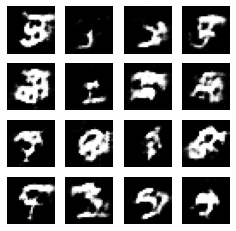

Tempo para processar época 1 foi de 68.50338888168335 segundos


In [35]:
treinar(X_treinamento, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

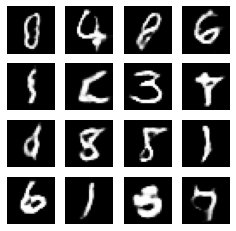

In [ ]:
seed_input = tf.random.normal([num_amostras, noise_dim])
preds = gerador(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> Mais implementações:

* https://github.com/robbiebarrat/art-DCGAN (baseado em DCGAN)
* https://github.com/tdrussell/IllustrationGAN (baseado em DCGAN)
* https://github.com/viuts/wgan-animefaces (baseado em WGAN)